# Diabetic Retinopathy Detection Using Deep Learning
## CM4605 Machine Vision Coursework

In [24]:
# Imports and Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, precision_recall_curve,
    cohen_kappa_score, matthews_corrcoef, auc
)
import sklearn
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, LearningRateScheduler
)
import cv2
from tqdm.notebook import tqdm
import random
import math
import time
from datetime import datetime
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate, Multiply, Add,
    Reshape, Dense, Dropout, Conv2D, BatchNormalization, Activation,
    MaxPooling2D, AveragePooling2D, SpatialDropout2D, Lambda
)
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
)

In [25]:
# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.keras.utils.set_random_seed(SEED)

In [26]:
# Set up GPU memory growth to avoid OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

## 1. Path Configuration

In [27]:
# Define paths for Data, Model and Logs
DATA_PATH = "D:\\MV_CW_Data"
IMAGE_PATH = os.path.join(DATA_PATH, "combined_images")
CSV_PATH = os.path.join(DATA_PATH, "cleaned_valid_image_labels.csv")
MODEL_SAVE_PATH = os.path.join(DATA_PATH, "models")
LOGS_PATH = os.path.join(DATA_PATH, "logs")

# Create necessary directories if they don't exist
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
os.makedirs(LOGS_PATH, exist_ok=True)

## 2. Data Loading and Exploration

In [53]:
# Load data
df = pd.read_csv(CSV_PATH)
print(f"Dataset shape: {df.shape}")
print(df.head())

Dataset shape: (10943, 2)
        id_code  diagnosis
0  000c1434d8d7          1
1  001639a390f0          1
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0



Class distribution:
diagnosis
1    5556
0    5387
Name: count, dtype: int64
Percentage of class 0: 49.23%
Percentage of class 1: 50.77%


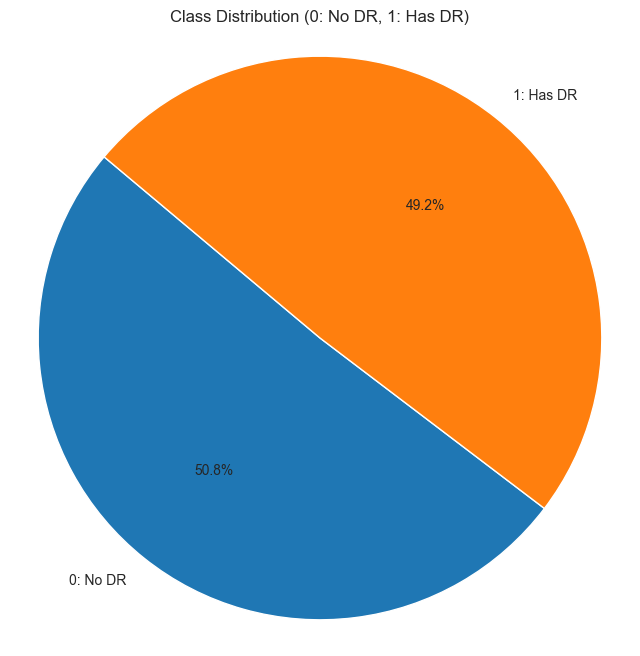

In [55]:
# Display class distribution statistics
print("\nClass distribution:")
class_counts = df['diagnosis'].value_counts()
print(class_counts)
print(f"Percentage of class 0: {class_counts[0] / len(df) * 100:.2f}%")
print(f"Percentage of class 1: {class_counts[1] / len(df) * 100:.2f}%")

# Visualize class distribution as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=['0: No DR', '1: Has DR'], autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution (0: No DR, 1: Has DR)')
plt.axis('equal')
plt.show()

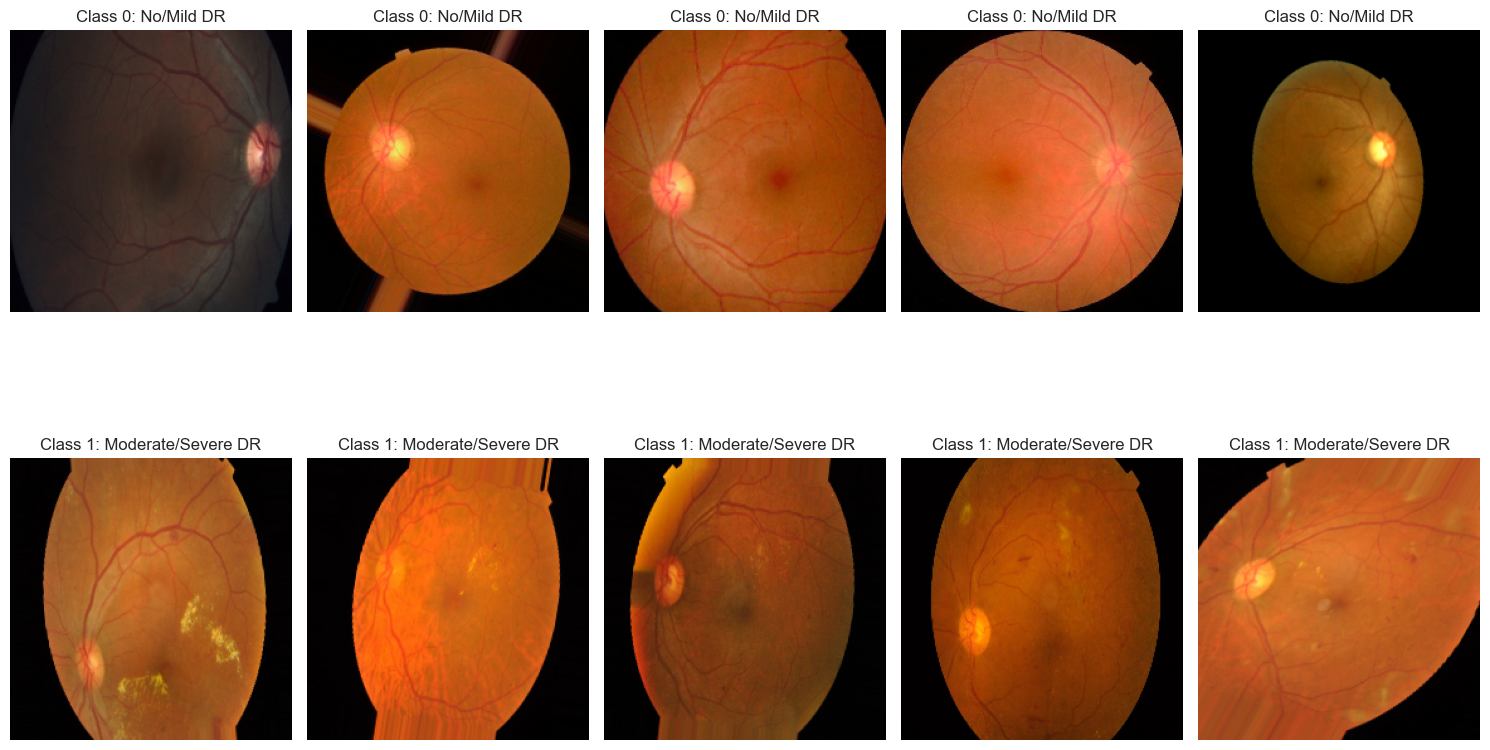

In [56]:
# Visualize sample images from each class
def display_sample_images(df, image_path, num_samples=5):
    plt.figure(figsize=(15, 10))

    # Get samples from each class
    class_0_samples = df[df['diagnosis'] == 0].sample(num_samples, random_state=SEED)
    class_1_samples = df[df['diagnosis'] == 1].sample(num_samples, random_state=SEED)

    # Display class 0 samples
    for i, (idx, row) in enumerate(class_0_samples.iterrows()):
        plt.subplot(2, num_samples, i + 1)
        img_path = os.path.join(image_path, f"{row['id_code']}.png")
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f"Class 0: No/Mild DR")
        plt.axis('off')

    # Display class 1 samples
    for i, (idx, row) in enumerate(class_1_samples.iterrows()):
        plt.subplot(2, num_samples, i + num_samples + 1)
        img_path = os.path.join(image_path, f"{row['id_code']}.png")
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f"Class 1: Moderate/Severe DR")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


display_sample_images(df, IMAGE_PATH)

## 3. Initial Hyperparameters 

In [57]:
# Initial hyperparameters (will be tuned later)
IMG_SIZE = 256  
BATCH_SIZE = 8

## 4. Image Preprocessing

In [58]:
# Enhanced preprocessing function with specialized retina processing
# The preprocessing pipeline includes: Circular Masking, CLAHE, Edge Enhancement using unsharp masking and normalization 
def preprocess_image(image_path, target_size=(IMG_SIZE, IMG_SIZE)):
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        # Handle corrupted images
        print(f"Warning: Could not read {image_path}")
        return np.zeros((target_size[0], target_size[1], 3), dtype=np.float32)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get original dimensions for aspect ratio preservation
    height, width = img.shape[:2]

    # Create circular mask for focusing on retina
    mask = np.zeros((height, width), dtype=np.uint8)
    center = (width // 2, height // 2)
    radius = min(width, height) // 2
    cv2.circle(mask, center, radius, 255, -1)

    # Apply mask to focus on retina region
    masked_img = cv2.bitwise_and(img, img, mask=mask)

    # Apply CLAHE to enhance contrast in LAB color space
    lab = cv2.cvtColor(masked_img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    enhanced_lab = cv2.merge((cl, a, b))
    enhanced_img = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(enhanced_img, (0, 0), 1)

    # Apply unsharp mask to enhance edges (useful for vessel structure)
    unsharp_img = cv2.addWeighted(enhanced_img, 1.5, blurred, -0.5, 0)

    # Resize with proper interpolation method
    img_resized = cv2.resize(unsharp_img, target_size, interpolation=cv2.INTER_AREA)

    # Normalize to [0, 1]
    img_normalized = img_resized / 255.0

    # Apply channel-wise normalization for better network convergence
    for i in range(3):
        mean = np.mean(img_normalized[:, :, i])
        std = np.std(img_normalized[:, :, i])
        img_normalized[:, :, i] = (img_normalized[:, :, i] - mean) / (std + 1e-7)

    return img_normalized

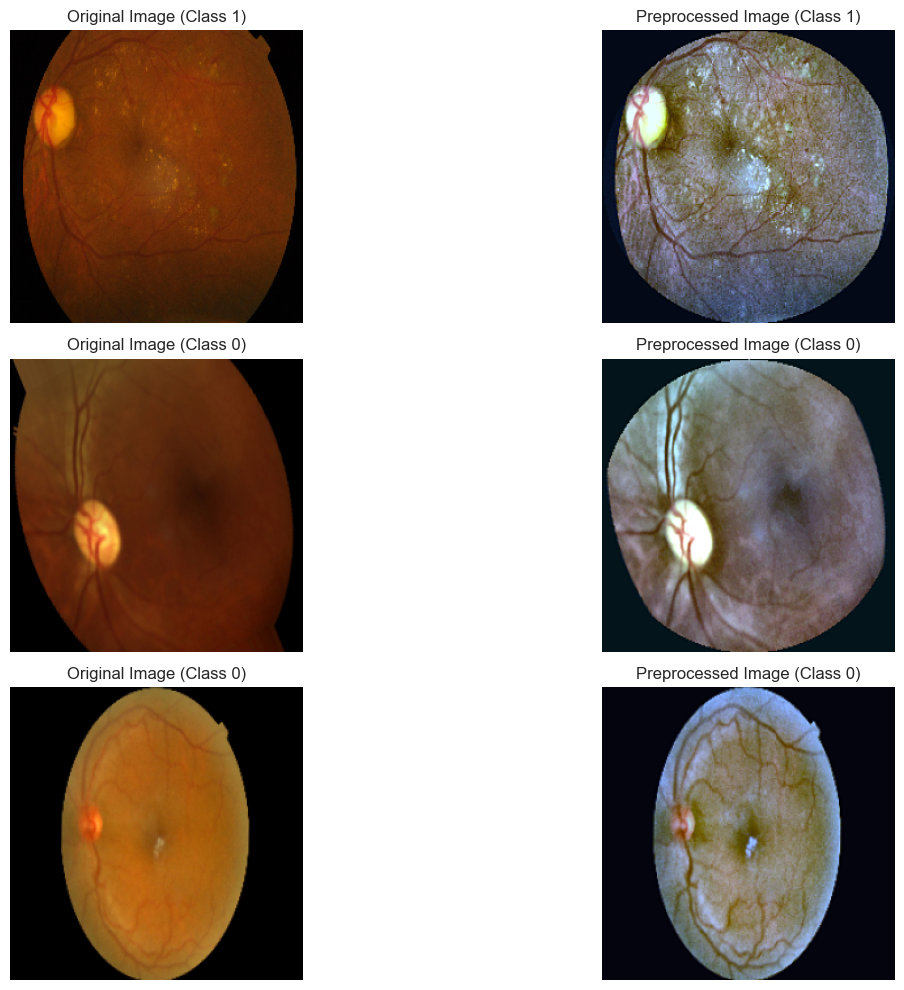

In [59]:
# Visualize the preprocessing effect
def display_preprocessing_effect(df, image_path, num_samples=3):
    plt.figure(figsize=(15, 10))

    # Get random samples
    samples = df.sample(num_samples, random_state=SEED)

    for i, (idx, row) in enumerate(samples.iterrows()):
        img_path = os.path.join(image_path, f"{row['id_code']}.png")

        # Original image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(img)
        plt.title(f"Original Image (Class {row['diagnosis']})")
        plt.axis('off')

        # Preprocessed image
        preprocessed_img = preprocess_image(img_path)
        # Reverse normalization for visualization
        preprocessed_img_vis = np.clip(preprocessed_img, -3, 3)  # Clip extreme values
        preprocessed_img_vis = (preprocessed_img_vis - preprocessed_img_vis.min()) / (
                    preprocessed_img_vis.max() - preprocessed_img_vis.min())

        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(preprocessed_img_vis)
        plt.title(f"Preprocessed Image (Class {row['diagnosis']})")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


display_preprocessing_effect(df, IMAGE_PATH)

## 5. Data Splitting

In [60]:
# Split the data into train, validation, and test sets with stratification to maintain class balance across all splits
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=SEED, stratify=df['diagnosis'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED, stratify=temp_df['diagnosis'])

print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Testing set: {len(test_df)} images")

# Verify class balance in splits
print("\nTraining set class distribution:")
print(train_df['diagnosis'].value_counts(normalize=True) * 100)

print("\nValidation set class distribution:")
print(val_df['diagnosis'].value_counts(normalize=True) * 100)

print("\nTest set class distribution:")
print(test_df['diagnosis'].value_counts(normalize=True) * 100)

Training set: 7660 images
Validation set: 1641 images
Testing set: 1642 images

Training set class distribution:
diagnosis
1    50.770235
0    49.229765
Name: proportion, dtype: float64

Validation set class distribution:
diagnosis
1    50.761731
0    49.238269
Name: proportion, dtype: float64

Test set class distribution:
diagnosis
1    50.791717
0    49.208283
Name: proportion, dtype: float64


## 6. Custom Data Generator

In [61]:
# Enhanced CustomDataGenerator
# This generator: Loads images batch by batch to save memory, applies preprocessing, handles errors and supports shuffling between epochs
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, image_dir, x_col, y_col, batch_size, target_size=(IMG_SIZE, IMG_SIZE),
                 shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.dataframe = dataframe.copy()
        self.image_dir = image_dir
        self.x_col = x_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataframe))
        if self.shuffle:
            np.random.shuffle(self.indexes)

        # Precompute file existence to avoid IO issues during training
        self.valid_files = {}
        for _, row in dataframe.iterrows():
            img_path = os.path.join(image_dir, f"{row[x_col]}.png")
            self.valid_files[row[x_col]] = os.path.exists(img_path)

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.dataframe.iloc[batch_indexes]

        batch_x = np.zeros((len(batch_df), self.target_size[0], self.target_size[1], 3), dtype=np.float32)
        batch_y = np.zeros((len(batch_df), 1), dtype=np.float32)

        for i, (_, row) in enumerate(batch_df.iterrows()):
            img_path = os.path.join(self.image_dir, f"{row[self.x_col]}.png")
            if self.valid_files.get(row[self.x_col], False):
                try:
                    batch_x[i] = preprocess_image(img_path, self.target_size)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
                    # Provide a zero-filled image on error
                    batch_x[i] = np.zeros((self.target_size[0], self.target_size[1], 3), dtype=np.float32)
            batch_y[i] = row[self.y_col]

        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

## 7. Attention Mechanisms

In [62]:
# Enhanced attention mechanism
# This attention mechanism works by: Squeezing spatial dimensions to capture channel-wise dependencies, exciting these values with a gating mechanism and rescaling the feature maps based on importance
def squeeze_excite_block(x, ratio=16):
    """
    Squeeze and Excitation block to recalibrate channel-wise feature responses
    """
    init = x
    filters = init.shape[-1]

    # Squeeze (global information embedding)
    se = GlobalAveragePooling2D()(init)
    se = Reshape((1, 1, filters))(se)

    # Excitation (adaptive recalibration)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    # Scale the input
    x = Multiply()([init, se])
    return x

In [63]:
# Spatial attention module to highlight important regions in the feature maps.
# This works by: Computing spatial statistics (average and max pooling), applying convolution to generate a spatial attention map and using this map to focus on important spatial regions
def spatial_attention_block(x):
    """
    Spatial attention module to highlight important regions
    """
    kernel_size = 7

    # Compute channel-wise statistics
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(x)
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(x)

    # Concatenate along the channel axis
    concat = Concatenate(axis=3)([avg_pool, max_pool])

    # Apply convolution to generate spatial attention map
    spatial = Conv2D(1, kernel_size, padding='same', activation='sigmoid',
                     kernel_initializer='he_normal', use_bias=False)(concat)

    # Apply spatial attention to input feature map
    x = Multiply()([x, spatial])
    return x

In [64]:
# Convolutional Block Attention Module (CBAM) combining channel and spatial attention.
# This sequential attention mechanism combines: Channel attention to emphasize important feature channels and spatial attention to focus on important regions

def cbam_block(x, ratio=16):
    """
    Convolutional Block Attention Module (CBAM)
    Combines channel and spatial attention
    """
    # Channel attention
    x = squeeze_excite_block(x, ratio)

    # Spatial attention
    x = spatial_attention_block(x)

    return x

## 8. Custom Loss Function

In [66]:
# Advanced focal loss with label smoothing for better training stability
# This combines:
# 1. Focal loss - to address class imbalance by down-weighting easy examples
# 2. Label smoothing - to prevent overconfidence and improve generalization
def focal_loss_with_smoothing(gamma=2.0, alpha=0.25, label_smoothing=0.1):
    """
    Focal loss with label smoothing for more stable training and improved generalization
    """

    def loss_fn(y_true, y_pred):
        # Apply label smoothing
        y_true = y_true * (1 - label_smoothing) + 0.5 * label_smoothing

        # Clip predictions for numerical stability
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())

        # Calculate cross entropy
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)

        # Calculate focal weight
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = K.pow((1.0 - p_t), gamma)

        # Apply weights to cross-entropy
        loss = alpha_factor * modulating_factor * cross_entropy
        return K.mean(loss)

    return loss_fn

## 9. Model Architecture

In [67]:
# Enhanced model architecture with modern techniques.
# Architecture highlights:
#   1. EfficientNetV2S backbone pre-trained on ImageNet
#   2. Custom attention mechanisms (CBAM)
#   3. Multi-scale feature aggregation
#   4. Skip connections for better gradient flow
#   5. Regularization via dropout and L2
def build_enhanced_model(dropout_rate=0.5, l2_reg=1e-5):
    """
    Build an enhanced deep learning model for DR detection
    with EfficientNetV2S backbone and custom components
    """
    # Set input shape
    input_shape = (IMG_SIZE, IMG_SIZE, 3)
    inputs = tf.keras.Input(shape=input_shape)
    
    # Use EfficientNetV2S
    base_model = applications.EfficientNetV2S(
        weights='imagenet',
        include_top=False,
        input_tensor=inputs
    )

    # Freeze early layers to prevent overfitting
    # Freeze first 70% of the layers to keep pre-trained features
    freeze_layers = int(len(base_model.layers) * 0.7)
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False

    # Get the output from the base model
    x = base_model.output

    # Apply custom post-processing to base model features
    x = cbam_block(x)

    # Global pooling with multiscale feature aggregation
    # Combine both average and max pooling for better feature representation
    gap = GlobalAveragePooling2D()(x)
    gmp = GlobalMaxPooling2D()(x)
    x = Concatenate()([gap, gmp])

    # First dense block 
    x1 = Dropout(dropout_rate)(x)
    x1 = Dense(1024, activation='relu', kernel_regularizer=l1_l2(l1=1e-6, l2=l2_reg))(x1)
    x1 = BatchNormalization()(x1)

    # Second dense block
    x2 = Dropout(dropout_rate * 0.8)(x1)
    x2 = Dense(512, activation='relu', kernel_regularizer=l1_l2(l1=1e-6, l2=l2_reg))(x2)
    x2 = BatchNormalization()(x2)

    # Add skip connection between dense layers for gradient flow
    x2 = Concatenate()([x2, Dense(512, activation='linear')(x1)])

    # Final classification block with reduced dropout
    x3 = Dropout(dropout_rate * 0.5)(x2)
    x3 = Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=1e-6, l2=l2_reg))(x3)
    x3 = BatchNormalization()(x3)

    # Output layer with sigmoid activation for binary classification
    outputs = Dense(1, activation='sigmoid')(x3)

    # Create model
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

## 10. Hyperparameter Optimization

In [68]:
# Advanced hyperparameter optimization 
# Perform advanced hyperparameter search with randomized exploration.
# This function:
#    1. Defines a hyperparameter search space
#    2. Randomly samples configurations
#    3. Trains models briefly to evaluate performance
#    4. Tracks the best parameters
def advanced_hyperparameter_search(train_df, val_df, image_path, num_trials=2):
    """
    Perform advanced hyperparameter search with expanded search space
    and more systematic evaluation
    """
    best_val_auc = 0
    best_params = {}
    results = []
    
    # Define a constant batch size instead of tuning it due to computer memory constraints
    BATCH_SIZE = 8  
    
    # Define an expanded hyperparameter search space
    param_grid = {
        'learning_rate': [1e-5, 3e-5, 5e-5, 8e-5, 1e-4, 3e-4],
        'dropout_rate': [0.3, 0.4, 0.5, 0.6, 0.7],
        'l2_reg': [1e-6, 1e-5, 3e-5, 1e-4]
    }

    # For each trial, sample hyperparameters, train a model briefly, and evaluate
    for i in range(num_trials):
        # Sample hyperparameters
        params = {
            'learning_rate': random.choice(param_grid['learning_rate']),
            'dropout_rate': random.choice(param_grid['dropout_rate']),
            'l2_reg': random.choice(param_grid['l2_reg'])
        }

        print(f"\nTrial {i + 1}/{num_trials}")
        print(f"Parameters: {params}")

        # Create data generators with the fixed batch size
        train_generator = CustomDataGenerator(
            train_df, image_path, 'id_code', 'diagnosis', BATCH_SIZE
        )

        val_generator = CustomDataGenerator(
            val_df, image_path, 'id_code', 'diagnosis', BATCH_SIZE, shuffle=False
        )

        # Build model with current hyperparameters
        K.clear_session()  # Clear backend session to avoid memory issues
        model = build_enhanced_model(
            dropout_rate=params['dropout_rate'],
            l2_reg=params['l2_reg']
        )

        # Compile model with focal loss and proper metrics
        optimizer = optimizers.Adam(learning_rate=params['learning_rate'])
        model.compile(
            optimizer=optimizer,
            loss=focal_loss_with_smoothing(gamma=2.0, alpha=0.25, label_smoothing=0.1),
            metrics=[
                'accuracy',
                tf.keras.metrics.AUC(name='auc'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
            ]
        )

        # Train for a few epochs to evaluate performance
        callbacks = [
            EarlyStopping(
                monitor='val_auc',
                patience=3,
                mode='max',
                restore_best_weights=True
            )
        ]

        # Keep the training short for hyperparameter search
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=2,  # Just a few epochs to evaluate
            callbacks=callbacks,
            verbose=1
        )

        # Get the best validation AUC achieved
        val_auc = max(history.history['val_auc'])

        # Save results
        params['val_auc'] = val_auc
        results.append(params)

        # Update the best parameters if needed
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_params = params.copy()

        print(f"Validation AUC: {val_auc:.4f}")
        print(f"Best validation AUC so far: {best_val_auc:.4f}")

        # Clean up to prevent memory leaks
        del model
        tf.keras.backend.clear_session()

    # Display results
    results_df = pd.DataFrame(results)
    print("\n===== Hyperparameter Tuning Results =====")
    print(results_df.sort_values('val_auc', ascending=False))

    print("\n===== Best Parameters =====")
    print(f"Best validation AUC: {best_val_auc:.4f}")
    print(f"Parameters: {best_params}")

    return best_params

## 11. Create Data Generators

In [69]:
# Create generators with initial batch size
train_generator = CustomDataGenerator(
    train_df, IMAGE_PATH, 'id_code', 'diagnosis', BATCH_SIZE
)

val_generator = CustomDataGenerator(
    val_df, IMAGE_PATH, 'id_code', 'diagnosis', BATCH_SIZE, shuffle=False
)

test_generator = CustomDataGenerator(
    test_df, IMAGE_PATH, 'id_code', 'diagnosis', BATCH_SIZE, shuffle=False
)

## 12. Hyperparameter optimization and model building

In [70]:
# Perform advanced hyperparameter search
print("Starting hyperparameter optimization...")
best_params = advanced_hyperparameter_search(train_df, val_df, IMAGE_PATH, num_trials=2)

Starting hyperparameter optimization...

Trial 1/2
Parameters: {'learning_rate': 8e-05, 'dropout_rate': 0.5, 'l2_reg': 0.0001}
Epoch 1/2
958/958 ━━━━━━━━━━━━━━━━━━━━ 1744s 2s/step - accuracy: 0.6835 - auc: 0.7453 - loss: 0.4533 - precision: 0.7208 - recall: 0.6389 - val_accuracy: 0.8361 - val_auc: 0.9599 - val_loss: 0.3637 - val_precision: 0.9796 - val_recall: 0.6915
Epoch 2/2
958/958 ━━━━━━━━━━━━━━━━━━━━ 1269s 1s/step - accuracy: 0.7848 - auc: 0.8758 - loss: 0.3902 - precision: 0.8578 - recall: 0.6841 - val_accuracy: 0.8672 - val_auc: 0.9650 - val_loss: 0.3475 - val_precision: 0.9680 - val_recall: 0.7635
Validation AUC: 0.9650
Best validation AUC so far: 0.9650

Trial 2/2
Parameters: {'learning_rate': 5e-05, 'dropout_rate': 0.6, 'l2_reg': 0.0001}
Epoch 1/2
958/958 ━━━━━━━━━━━━━━━━━━━━ 1103s 1s/step - accuracy: 0.6190 - auc: 0.6705 - loss: 0.4772 - precision: 0.6270 - recall: 0.5878 - val_accuracy: 0.8324 - val_auc: 0.9508 - val_loss: 0.3661 - val_precision: 0.9827 - val_recall: 0.6819

In [71]:
# Extract optimal hyperparameters
DROPOUT_RATE = best_params['dropout_rate']
LEARNING_RATE = best_params['learning_rate']
L2_REG = best_params['l2_reg']

print(f"Using optimal hyperparameters: Learning Rate={LEARNING_RATE}, Dropout={DROPOUT_RATE}, "
      f"L2 Regularization={L2_REG}, Batch Size={BATCH_SIZE}")

Using optimal hyperparameters: Learning Rate=8e-05, Dropout=0.5, L2 Regularization=0.0001, Batch Size=8


In [73]:
# Build the model with optimized parameters
model = build_enhanced_model(dropout_rate=DROPOUT_RATE, l2_reg=L2_REG)

In [74]:
# Compile the model with optimized learning rate and focal loss
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE * 2.0)
model.compile(
    optimizer=optimizer,
    loss=focal_loss_with_smoothing(gamma=2.0, alpha=0.25, label_smoothing=0.1),
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.FalsePositives(name='false_positives'),
        tf.keras.metrics.FalseNegatives(name='false_negatives')
    ]
)

In [75]:
# Display model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        648 │ rescaling[0][0]   │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │         96 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │      5,184 │ stem_activation[… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 128, 128,  │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 128, 128,  │          0 │ block1a_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 128, 128,  │          0 │ block1a_project_… │
│                     │ 24)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 128, 128,  │      5,184 │ block1a_add[0][0] │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 128, 128,  │         96 │ block1b_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 128, 128,  │          0 │ block1b_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 128, 128,  │          0 │ block1b_project_… │
│ (Dropout)           │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 128, 128,  │          0 │ block1b_drop[0][… │
│                     │ 24)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 64, 64,    │     20,736 │ block1b_add[0][0] │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 64, 64,    │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 64, 64,    │          0 │ block2a_expand_b

 Total params: 24,478,147 (93.38 MB)

 Trainable params: 14,524,643 (55.41 MB)

 Non-trainable params: 9,953,504 (37.97 MB)

## 13. Model Training

In [76]:
# Set up callbacks with advanced monitoring and scheduling
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [
    # Early stopping with longer patience and AUC monitoring
    EarlyStopping(
        monitor='val_auc',
        patience=6,
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),
    
    # Enhanced learning rate reduction plateau for fine-tuning
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,  # More aggressive reduction
        patience=2,  # Reduced patience
        min_lr=1e-7,
        verbose=1
    ),

    # Model checkpoint to save best model
    ModelCheckpoint(
        filepath=os.path.join(MODEL_SAVE_PATH, f'dr_model_{timestamp}_best.h5'),
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    ),

    # TensorBoard for monitoring training
    TensorBoard(
        log_dir=os.path.join(LOGS_PATH, f'logs_{timestamp}'),
        histogram_freq=1,
        write_graph=True,
        update_freq='epoch'
    )
]

In [77]:
# Train the model with optimized settings
EPOCHS = 10  

In [78]:
print("\nStarting model training with optimized parameters...")
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Starting model training with optimized parameters...
Epoch 1/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6916 - auc: 0.7671 - false_negatives: 706.5334 - false_positives: 371.9561 - loss: 0.4535 - precision: 0.7400 - recall: 0.6257
Epoch 1: val_auc improved from -inf to 0.94798, saving model to D:\MV_CW_Data\models\dr_model_20250326-202702_best.h5


958/958 ━━━━━━━━━━━━━━━━━━━━ 1442s 1s/step - accuracy: 0.6916 - auc: 0.7672 - false_negatives: 707.1866 - false_positives: 372.2221 - loss: 0.4534 - precision: 0.7400 - recall: 0.6258 - val_accuracy: 0.7172 - val_auc: 0.9480 - val_false_negatives: 464.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.3849 - val_precision: 1.0000 - val_recall: 0.4430 - learning_rate: 1.6000e-04
Epoch 2/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7950 - auc: 0.8852 - false_negatives: 584.4019 - false_positives: 173.7944 - loss: 0.3764 - precision: 0.8781 - recall: 0.6901
Epoch 2: val_auc improved from 0.94798 to 0.97335, saving model to D:\MV_CW_Data\models\dr_model_20250326-202702_best.h5


958/958 ━━━━━━━━━━━━━━━━━━━━ 1193s 1s/step - accuracy: 0.7950 - auc: 0.8852 - false_negatives: 584.9771 - false_positives: 173.9520 - loss: 0.3764 - precision: 0.8781 - recall: 0.6901 - val_accuracy: 0.8172 - val_auc: 0.9734 - val_false_negatives: 299.0000 - val_false_positives: 1.0000 - val_loss: 0.3338 - val_precision: 0.9981 - val_recall: 0.6411 - learning_rate: 1.6000e-04
Epoch 3/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8401 - auc: 0.9273 - false_negatives: 476.0439 - false_positives: 120.3434 - loss: 0.3356 - precision: 0.9195 - recall: 0.7473
Epoch 3: val_auc improved from 0.97335 to 0.98602, saving model to D:\MV_CW_Data\models\dr_model_20250326-202702_best.h5


958/958 ━━━━━━━━━━━━━━━━━━━━ 1263s 1s/step - accuracy: 0.8401 - auc: 0.9273 - false_negatives: 476.5078 - false_positives: 120.4578 - loss: 0.3356 - precision: 0.9195 - recall: 0.7473 - val_accuracy: 0.9074 - val_auc: 0.9860 - val_false_negatives: 140.0000 - val_false_positives: 12.0000 - val_loss: 0.2949 - val_precision: 0.9830 - val_recall: 0.8319 - learning_rate: 1.6000e-04
Epoch 4/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8633 - auc: 0.9422 - false_negatives: 404.6201 - false_positives: 119.4217 - loss: 0.3038 - precision: 0.9249 - recall: 0.7905
Epoch 4: val_auc improved from 0.98602 to 0.99016, saving model to D:\MV_CW_Data\models\dr_model_20250326-202702_best.h5


958/958 ━━━━━━━━━━━━━━━━━━━━ 1260s 1s/step - accuracy: 0.8633 - auc: 0.9422 - false_negatives: 405.0313 - false_positives: 119.5328 - loss: 0.3038 - precision: 0.9249 - recall: 0.7905 - val_accuracy: 0.9427 - val_auc: 0.9902 - val_false_negatives: 83.0000 - val_false_positives: 11.0000 - val_loss: 0.2604 - val_precision: 0.9855 - val_recall: 0.9004 - learning_rate: 1.6000e-04
Epoch 5/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8967 - auc: 0.9609 - false_negatives: 318.9885 - false_positives: 91.6420 - loss: 0.2662 - precision: 0.9495 - recall: 0.8414
Epoch 5: val_auc did not improve from 0.99016
958/958 ━━━━━━━━━━━━━━━━━━━━ 1816s 2s/step - accuracy: 0.8967 - auc: 0.9609 - false_negatives: 319.3389 - false_positives: 91.7331 - loss: 0.2662 - precision: 0.9495 - recall: 0.8414 - val_accuracy: 0.9378 - val_auc: 0.9869 - val_false_negatives: 91.0000 - val_false_positives: 11.0000 - val_loss: 0.2323 - val_precision: 0.9854 - val_recall: 0.8908 - learning_rate: 1.6000e-04
Epoch 

958/958 ━━━━━━━━━━━━━━━━━━━━ 1183s 1s/step - accuracy: 0.8975 - auc: 0.9628 - false_negatives: 308.3107 - false_positives: 82.2054 - loss: 0.2353 - precision: 0.9527 - recall: 0.8397 - val_accuracy: 0.9452 - val_auc: 0.9909 - val_false_negatives: 76.0000 - val_false_positives: 14.0000 - val_loss: 0.2056 - val_precision: 0.9818 - val_recall: 0.9088 - learning_rate: 1.6000e-04
Epoch 7/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8946 - auc: 0.9646 - false_negatives: 307.1117 - false_positives: 83.0386 - loss: 0.2070 - precision: 0.9536 - recall: 0.8349
Epoch 7: val_auc improved from 0.99094 to 0.99315, saving model to D:\MV_CW_Data\models\dr_model_20250326-202702_best.h5


958/958 ━━━━━━━━━━━━━━━━━━━━ 1186s 1s/step - accuracy: 0.8946 - auc: 0.9646 - false_negatives: 307.3994 - false_positives: 83.1137 - loss: 0.2070 - precision: 0.9536 - recall: 0.8349 - val_accuracy: 0.9555 - val_auc: 0.9932 - val_false_negatives: 62.0000 - val_false_positives: 11.0000 - val_loss: 0.1729 - val_precision: 0.9859 - val_recall: 0.9256 - learning_rate: 1.6000e-04
Epoch 8/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9108 - auc: 0.9716 - false_negatives: 278.0136 - false_positives: 71.6795 - loss: 0.1776 - precision: 0.9594 - recall: 0.8612
Epoch 8: val_auc improved from 0.99315 to 0.99320, saving model to D:\MV_CW_Data\models\dr_model_20250326-202702_best.h5


958/958 ━━━━━━━━━━━━━━━━━━━━ 1207s 1s/step - accuracy: 0.9108 - auc: 0.9716 - false_negatives: 278.2951 - false_positives: 71.7539 - loss: 0.1775 - precision: 0.9594 - recall: 0.8612 - val_accuracy: 0.9305 - val_auc: 0.9932 - val_false_negatives: 107.0000 - val_false_positives: 7.0000 - val_loss: 0.1457 - val_precision: 0.9905 - val_recall: 0.8715 - learning_rate: 1.6000e-04
Epoch 9/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9227 - auc: 0.9763 - false_negatives: 236.4948 - false_positives: 58.1952 - loss: 0.1473 - precision: 0.9648 - recall: 0.8763
Epoch 9: val_auc improved from 0.99320 to 0.99387, saving model to D:\MV_CW_Data\models\dr_model_20250326-202702_best.h5


958/958 ━━━━━━━━━━━━━━━━━━━━ 1206s 1s/step - accuracy: 0.9227 - auc: 0.9763 - false_negatives: 236.7518 - false_positives: 58.2586 - loss: 0.1473 - precision: 0.9648 - recall: 0.8763 - val_accuracy: 0.9275 - val_auc: 0.9939 - val_false_negatives: 115.0000 - val_false_positives: 4.0000 - val_loss: 0.1176 - val_precision: 0.9945 - val_recall: 0.8619 - learning_rate: 1.6000e-04
Epoch 10/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9214 - auc: 0.9766 - false_negatives: 236.1409 - false_positives: 60.8946 - loss: 0.1189 - precision: 0.9639 - recall: 0.8768
Epoch 10: val_auc improved from 0.99387 to 0.99460, saving model to D:\MV_CW_Data\models\dr_model_20250326-202702_best.h5


958/958 ━━━━━━━━━━━━━━━━━━━━ 1203s 1s/step - accuracy: 0.9214 - auc: 0.9766 - false_negatives: 236.3681 - false_positives: 60.9458 - loss: 0.1189 - precision: 0.9639 - recall: 0.8768 - val_accuracy: 0.9506 - val_auc: 0.9946 - val_false_negatives: 72.0000 - val_false_positives: 9.0000 - val_loss: 0.0893 - val_precision: 0.9883 - val_recall: 0.9136 - learning_rate: 1.6000e-04
Restoring model weights from the end of the best epoch: 10.


## 14. Training Visualization

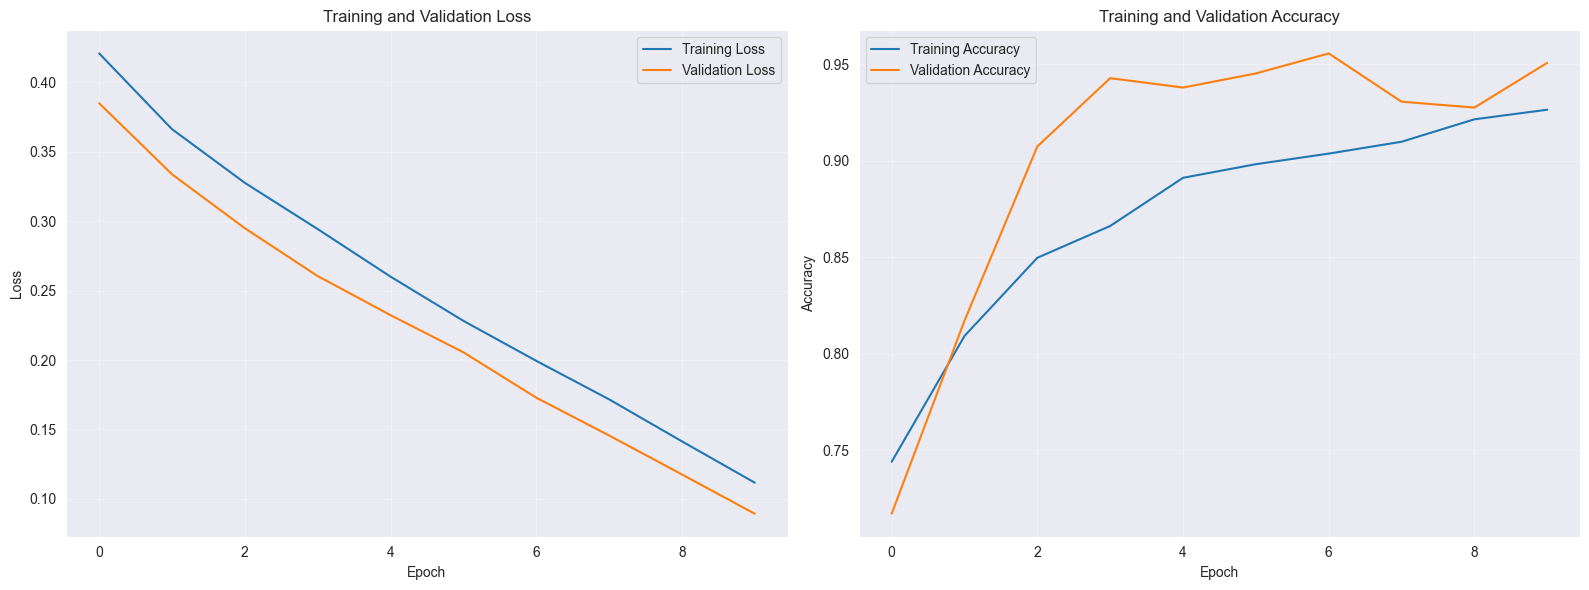

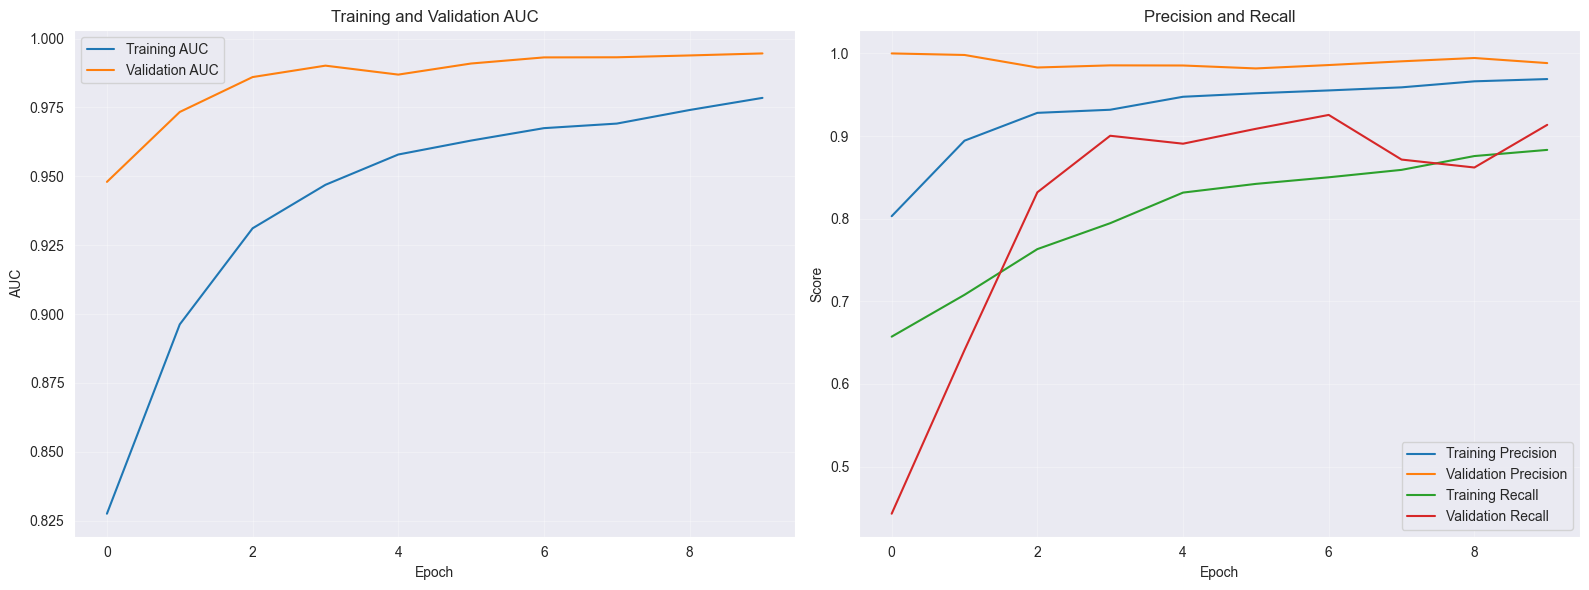

In [79]:
# Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Plot other metrics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot AUC
    ax1.plot(history.history['auc'], label='Training AUC')
    ax1.plot(history.history['val_auc'], label='Validation AUC')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('AUC')
    ax1.set_title('Training and Validation AUC')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot Precision/Recall
    ax2.plot(history.history['precision'], label='Training Precision')
    ax2.plot(history.history['val_precision'], label='Validation Precision')
    ax2.plot(history.history['recall'], label='Training Recall')
    ax2.plot(history.history['val_recall'], label='Validation Recall')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Score')
    ax2.set_title('Precision and Recall')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_training_history(history)

## 15. Model Evaluation

In [80]:
# Load best model for evaluation (to ensure we use the best weights)
model.load_weights(os.path.join(MODEL_SAVE_PATH, f'dr_model_{timestamp}_best.h5'))

In [81]:
# Evaluate the model on the test set
print("\nEvaluating model on test set...")
test_results = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test AUC: {test_results[2]:.4f}")
print(f"Test Precision: {test_results[3]:.4f}")
print(f"Test Recall: {test_results[4]:.4f}")


Evaluating model on test set...
206/206 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.9589 - auc: 0.9931 - false_negatives: 30.9565 - false_positives: 3.9565 - loss: 0.0893 - precision: 0.9911 - recall: 0.9276
Test Loss: 0.0903
Test Accuracy: 0.9549
Test AUC: 0.9925
Test Precision: 0.9872
Test Recall: 0.9233


In [82]:
# Predict on test data for additional metrics and visualizations
y_true = []     # True labels
y_pred = []     # Binary predictions
y_pred_proba = []       # Probability Scores

print("\nGenerating predictions for detailed metrics...")
for i in range(len(test_generator)):
    x_batch, y_batch = test_generator[i]
    pred_batch = model.predict(x_batch)

    y_true.extend(y_batch.flatten())
    y_pred_proba.extend(pred_batch.flatten())
    y_pred.extend((pred_batch > 0.5).astype(int).flatten())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

# Compute comprehensive metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc_roc = roc_auc_score(y_true, y_pred_proba)
kappa = cohen_kappa_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

print("\n======= Comprehensive Evaluation Metrics =======")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")



Generating predictions for detailed metrics...
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━

## 16. Visualizations and Explainability

In [95]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    """
    Create a detailed, well-formatted confusion matrix plot.
    
    Parameters:
    - y_true: True labels
    - y_pred: Predicted labels
    - title: Optional title for the plot
    """
    plt.figure(figsize=(8, 6))
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    
    # Use a slightly modified heatmap approach
    sns.heatmap(cm, 
                annot=True,      # Show numerical values
                fmt='d',         # Integer formatting
                cmap='Blues',    # Color scheme
                cbar=True,       # Show color bar
                square=True,     # Ensure square cells
                linewidths=0.5,  # Add cell borders
                annot_kws={"size": 10})  # Annotation text size
    
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

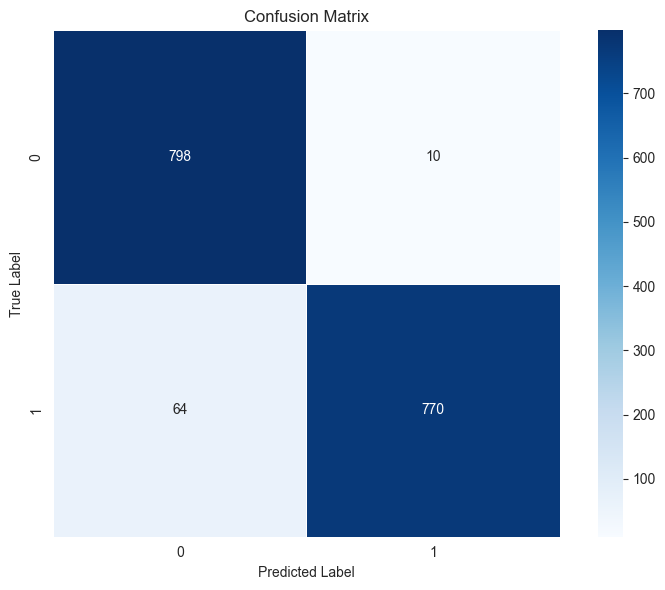

In [96]:
plot_confusion_matrix(y_true, y_pred)

In [97]:
def plot_performance_curves(y_true, y_pred_proba):
    """
    Create ROC and Precision-Recall curves.
    
    Parameters:
    - y_true: True labels
    - y_pred_proba: Predicted probabilities
    """
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # ROC Curve
    fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, y_pred_proba)
    auc_roc = sklearn.metrics.auc(fpr, tpr)
    
    ax1.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_roc:.4f})')
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)
    
    # Precision-Recall Curve
    precision_values, recall_values, _ = sklearn.metrics.precision_recall_curve(y_true, y_pred_proba)
    pr_auc = sklearn.metrics.auc(recall_values, precision_values)
    
    ax2.plot(recall_values, precision_values, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
    ax2.axhline(y=sum(y_true)/len(y_true), color='red', linestyle='--', label='Baseline')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend(loc="best")
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

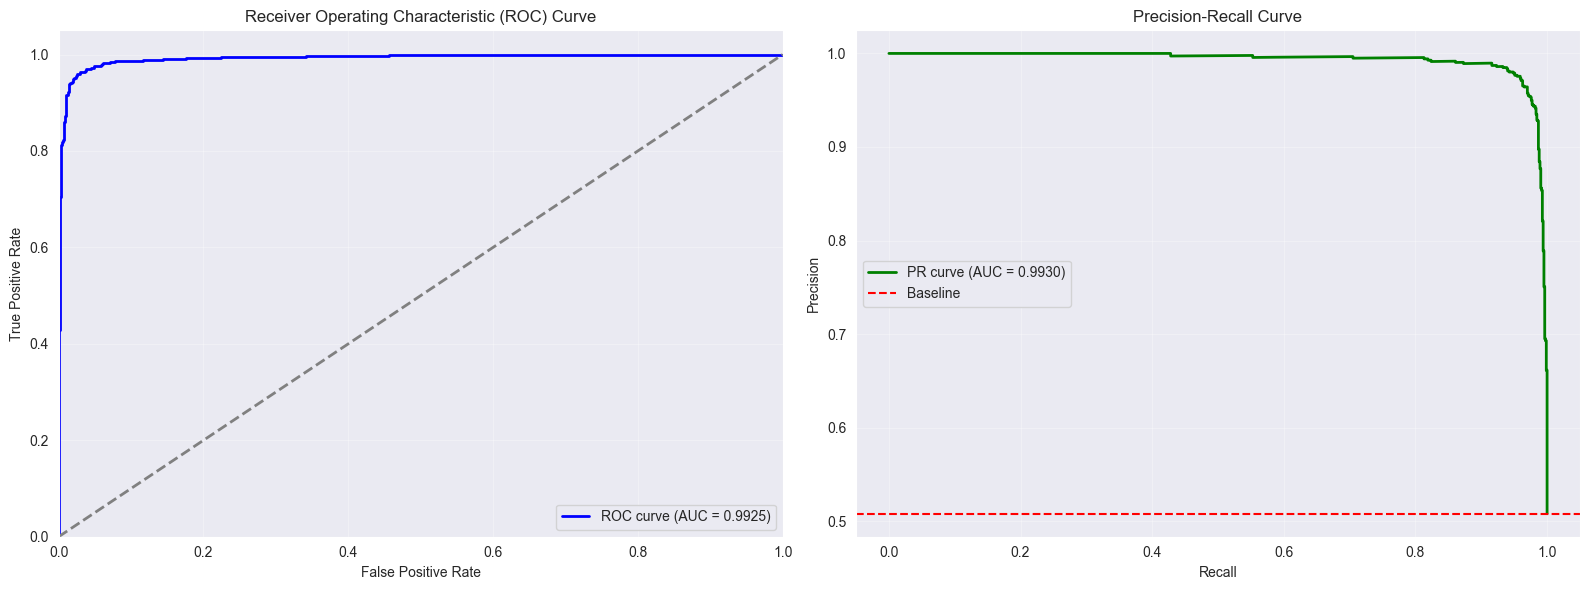

In [98]:
plot_performance_curves(y_true, y_pred_proba)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

C:\Users\HP\AppData\Local\Temp\ipykernel_10480\1309012591.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_df['confidence'] = np.abs(misclassified_df['pred_prob'] - 0.5) + 0.5


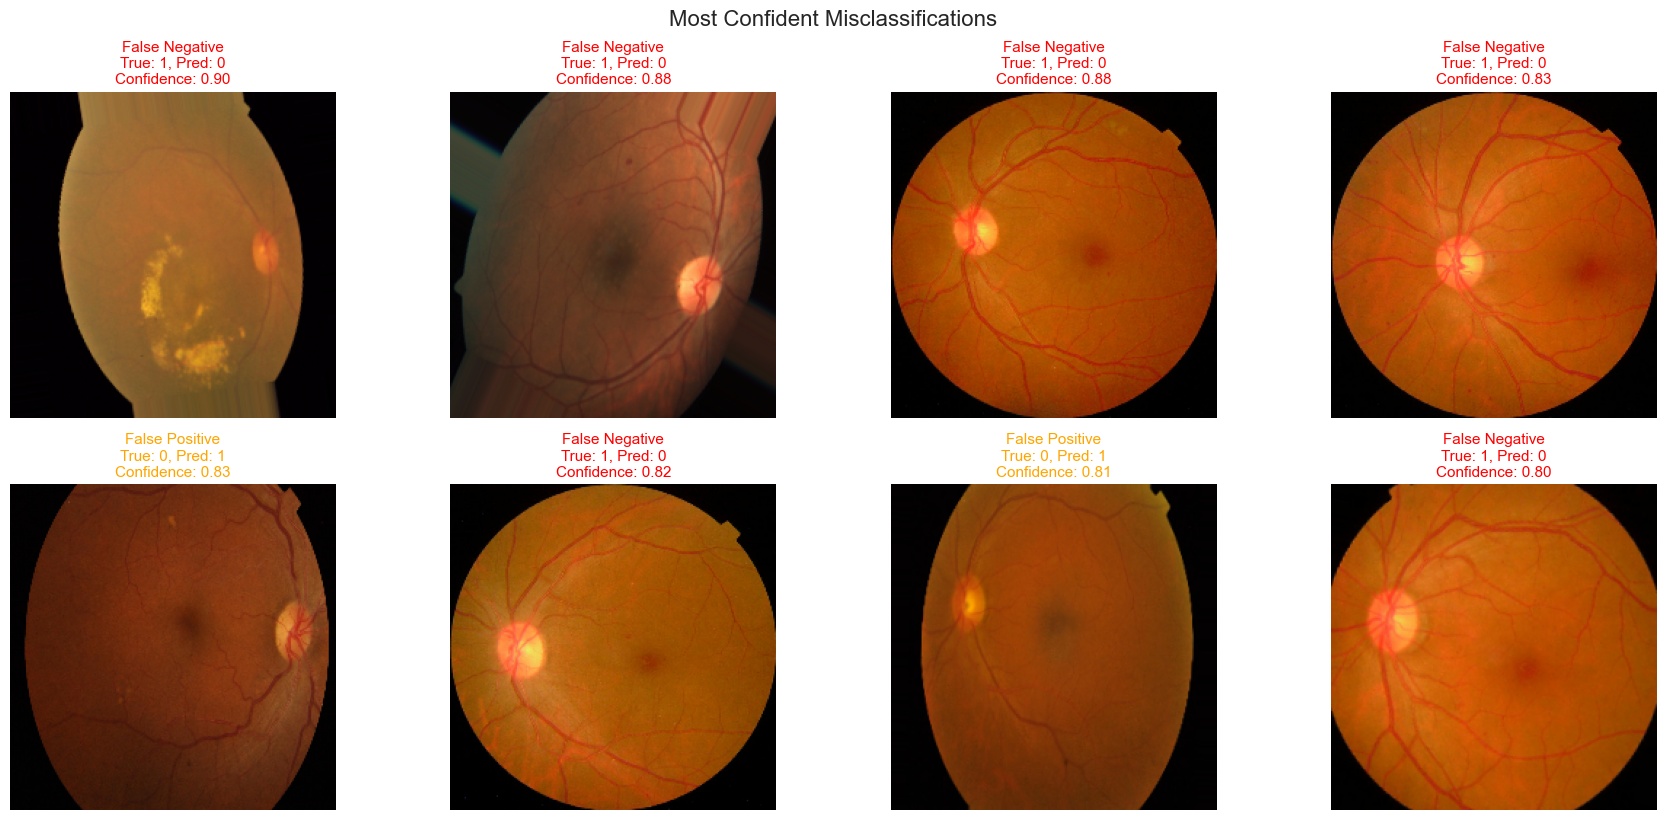

In [99]:
# Add misclassification visualization
def visualize_misclassifications(model, test_df, image_path, num_samples=8):
    """
    Visualize misclassified images to understand model failures
    """
    # Get predictions for all test samples
    all_probs = []
    all_true = []
    all_ids = []
    
    for i in range(len(test_generator)):
        x_batch, y_batch = test_generator[i]
        batch_preds = model.predict(x_batch)
        
        for j in range(len(batch_preds)):
            if i * BATCH_SIZE + j < len(test_df):
                img_id = test_df.iloc[i * BATCH_SIZE + j]['id_code']
                all_ids.append(img_id)
                all_probs.append(batch_preds[j][0])
                all_true.append(y_batch[j][0])
    
    # Convert to DataFrame for easier analysis
    pred_df = pd.DataFrame({
        'id_code': all_ids,
        'true_class': all_true,
        'pred_prob': all_probs
    })
    
    # Get misclassifications
    pred_df['predicted_class'] = (pred_df['pred_prob'] > 0.5).astype(int)
    pred_df['misclassified'] = pred_df['true_class'] != pred_df['predicted_class']
    
    # Filter for misclassifications
    misclassified_df = pred_df[pred_df['misclassified']]
    
    if len(misclassified_df) == 0:
        print("No misclassifications found in the test set!")
        return
    
    # Prioritize the most confident wrong predictions
    misclassified_df['confidence'] = np.abs(misclassified_df['pred_prob'] - 0.5) + 0.5
    samples = misclassified_df.nlargest(num_samples, 'confidence')
    
    # Set up the figure grid based on number of samples
    cols = 4
    rows = (num_samples + cols - 1) // cols
    plt.figure(figsize=(18, 4 * rows))
    
    for i, (idx, row) in enumerate(samples.iterrows()):
        img_path = os.path.join(image_path, f"{row['id_code']}.png")
        
        # Load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Plot
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        
        # Determine error type
        if row['true_class'] == 1 and row['predicted_class'] == 0:
            error_type = "False Negative"
            color = 'red'  # More severe error in medical context
        else:
            error_type = "False Positive"
            color = 'orange'
            
        plt.title(f"{error_type}\nTrue: {int(row['true_class'])}, Pred: {int(row['predicted_class'])}\nConfidence: {row['confidence']:.2f}", 
                  color=color, fontsize=11)
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle("Most Confident Misclassifications", fontsize=16, y=1.02)
    plt.show()

# Visualize misclassifications
visualize_misclassifications(model, test_df, IMAGE_PATH, num_samples=8)

## 17. Explainability: GRAD-CAM Visualization

Using layer 'top_conv' for Grad-CAM visualization
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━

C:\Users\HP\PycharmProjects\MV_CW2\venv\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


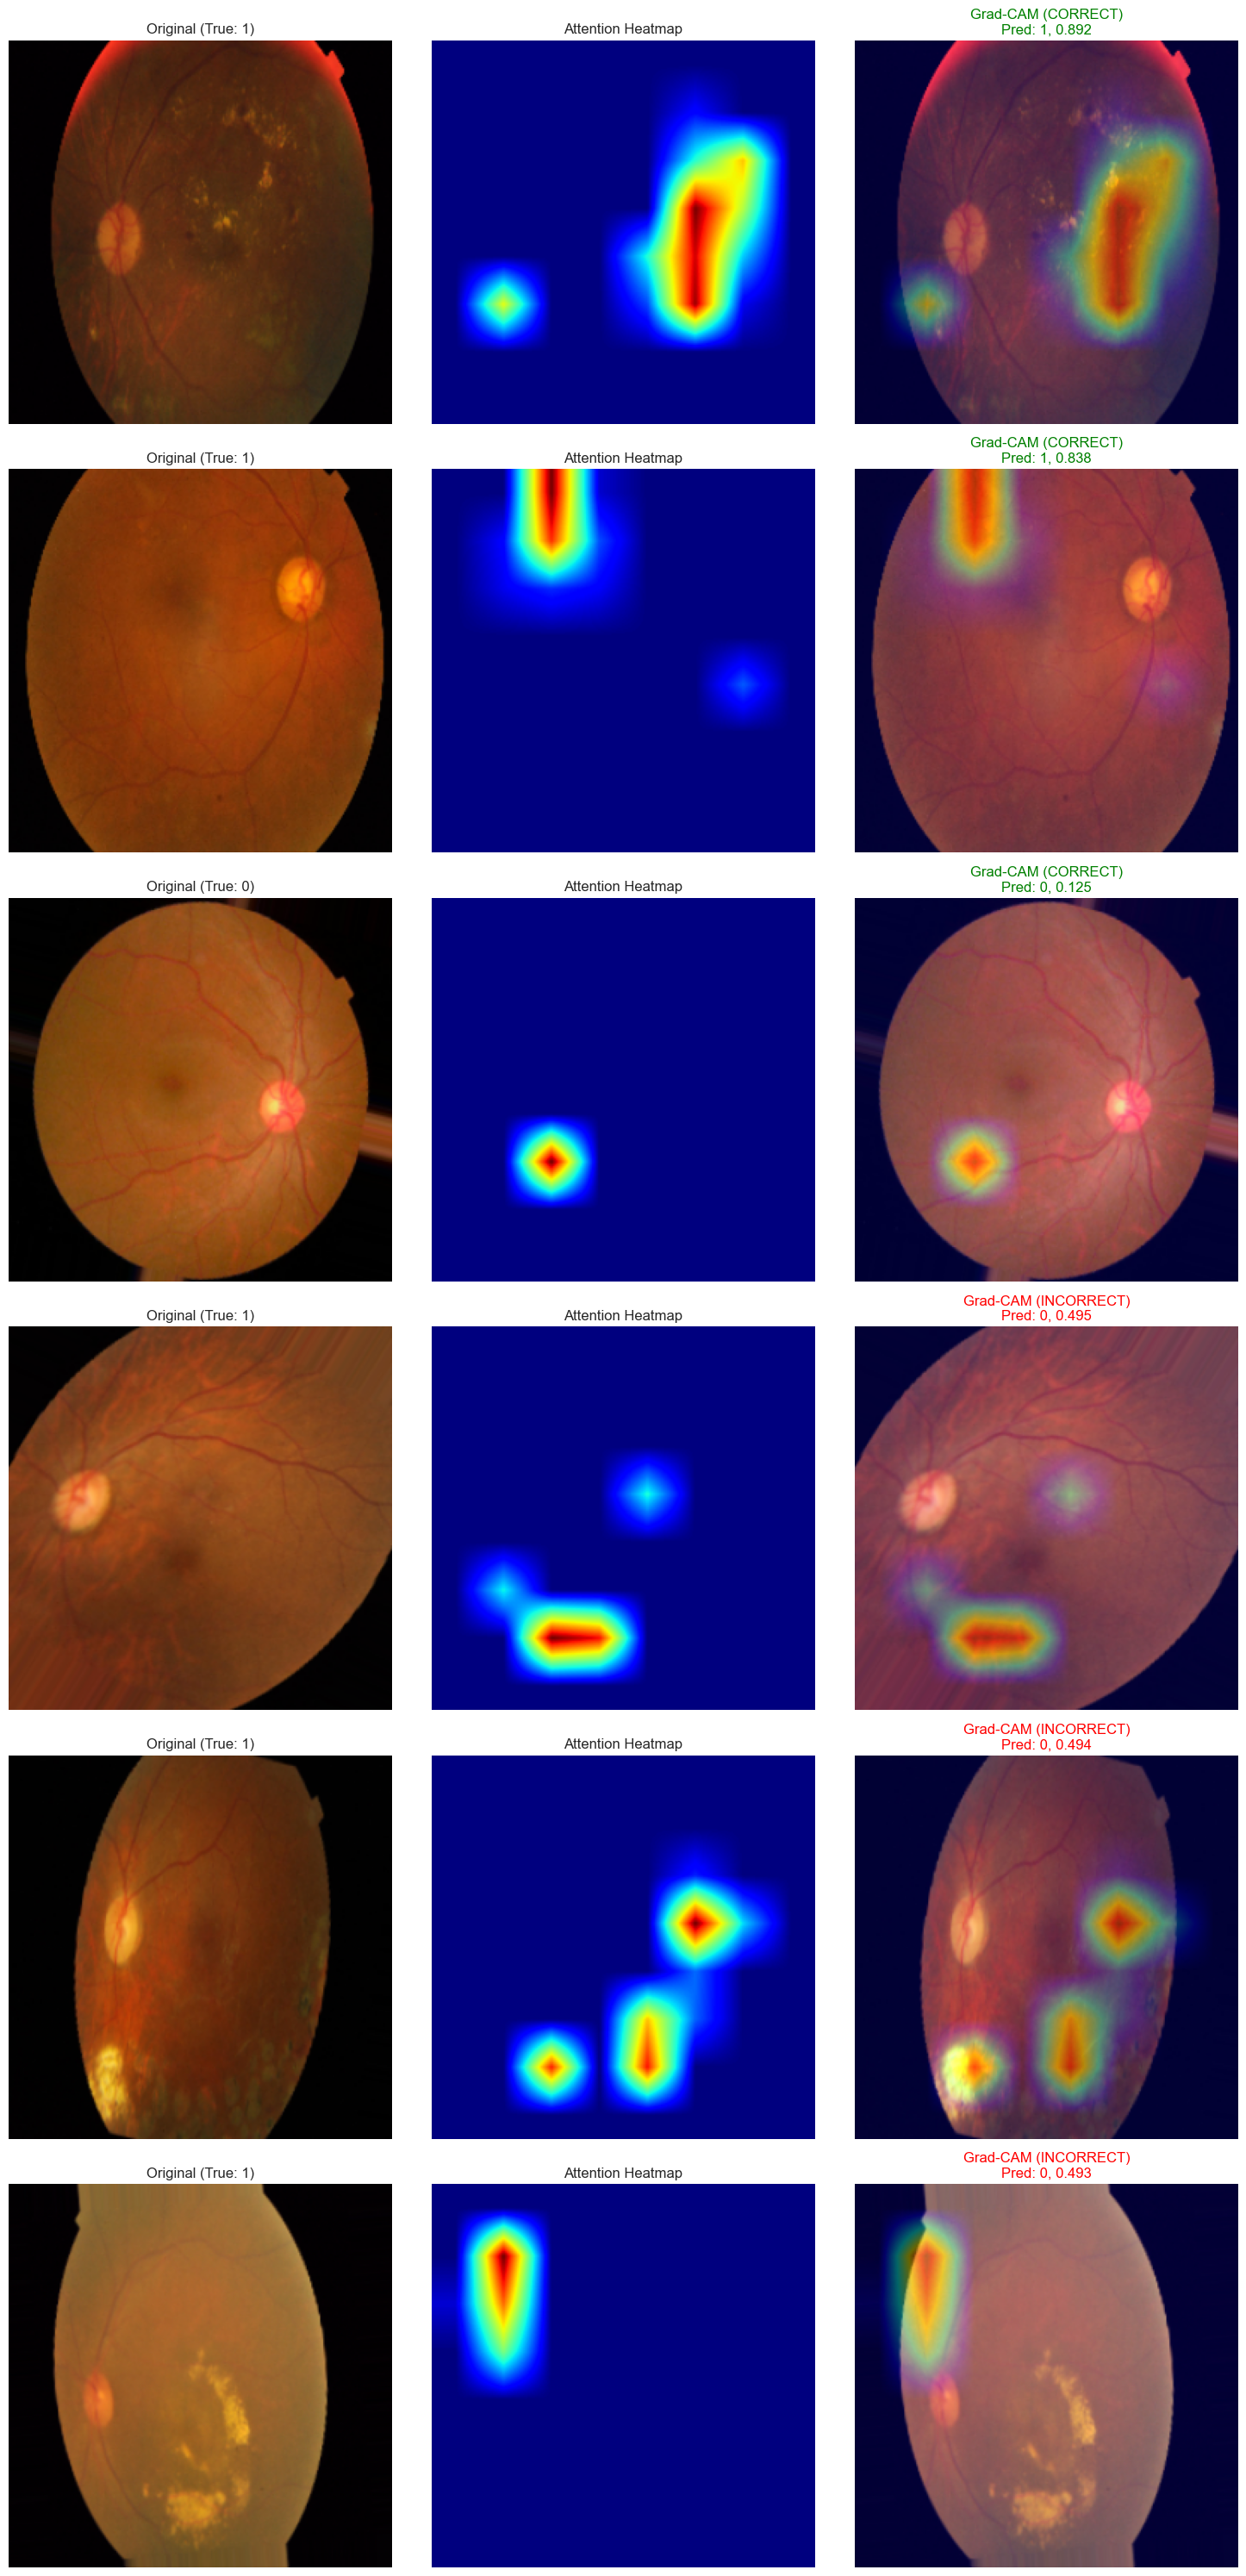

In [102]:
# Function for Grad-CAM visualization
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generate Grad-CAM heatmap for visualization of model attention
    """
    # Create a model that maps the input image to the activations of the last conv layer
    # and the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Get the score for the specific prediction index
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Gradient of the output with respect to the last conv layer output
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Vector of mean intensity of the gradient over feature map channels
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight feature maps by importance
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


# Enhanced display_gradcam function
def display_gradcam(img_path, heatmap, alpha=0.4):
    """
    Display Grad-CAM heatmap overlaid on original image
    """
    # Load and preprocess the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Resize heatmap to match image dimensions
    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))

    # Convert heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert to RGB for superimposition
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Superimpose the heatmap
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    return img, superimposed_img


# Function to visualize Grad-CAM for multiple samples
def visualize_gradcam_samples(model, test_df, image_path, num_samples=4):
    """
    Visualize Grad-CAM for multiple sample images
    """
    # Find an appropriate layer for Grad-CAM visualization
    last_conv_layer = None

    # Only look for EfficientNetV2S layers
    target_layers = ['top_conv', 'block6a_project_conv', 'block5d_project_conv']

    # Try to find the target layer
    for layer_name in target_layers:
        try:
            if model.get_layer(layer_name) is not None:
                last_conv_layer = layer_name
                break
        except:
            continue

    # Fallback: find any convolutional layer
    if last_conv_layer is None:
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                last_conv_layer = layer.name
                break

    if last_conv_layer is None:
        print("Could not find an appropriate layer for Grad-CAM visualization.")
        return

    print(f"Using layer '{last_conv_layer}' for Grad-CAM visualization")

    # Get sample images from both classes, focusing on difficult cases
    # First, get predicted probabilities for all test samples
    all_probs = []
    all_true = []
    all_ids = []

    for i in range(len(test_generator)):
        x_batch, y_batch = test_generator[i]
        batch_preds = model.predict(x_batch)

        for j in range(len(batch_preds)):
            if i * BATCH_SIZE + j < len(test_df):
                img_id = test_df.iloc[i * BATCH_SIZE + j]['id_code']
                all_ids.append(img_id)
                all_probs.append(batch_preds[j][0])
                all_true.append(y_batch[j][0])

    # Convert to DataFrame for easier analysis
    pred_df = pd.DataFrame({
        'id_code': all_ids,
        'true_class': all_true,
        'pred_prob': all_probs
    })

    # Calculate distance from decision boundary
    pred_df['distance'] = abs(pred_df['pred_prob'] - 0.5)

    # Select samples: some correct predictions and some borderline/incorrect predictions
    correct_df = pred_df[pred_df['true_class'] == (pred_df['pred_prob'] > 0.5).astype(int)]
    incorrect_df = pred_df[pred_df['true_class'] != (pred_df['pred_prob'] > 0.5).astype(int)]

    # Choose samples
    n_correct = min(num_samples // 2, len(correct_df))
    n_incorrect = min(num_samples - n_correct, len(incorrect_df))

    correct_samples = correct_df.sample(n_correct)

    if n_incorrect > 0:
        # Get the most challenging incorrect predictions
        incorrect_samples = incorrect_df.nsmallest(n_incorrect, 'distance')
        samples = pd.concat([correct_samples, incorrect_samples])
    else:
        # If no incorrect predictions, use all correct ones
        samples = correct_samples

    # Set up the figure
    plt.figure(figsize=(15, 5 * len(samples)))

    for i, (idx, row) in enumerate(samples.iterrows()):
        img_path = os.path.join(image_path, f"{row['id_code']}.png")

        # Preprocess the image
        img = preprocess_image(img_path)
        img_array = np.expand_dims(img, axis=0)

        # Get prediction
        prediction = model.predict(img_array)[0][0]
        predicted_class = 1 if prediction > 0.5 else 0

        # Generate Grad-CAM heatmap
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer)

        # Display original image and Grad-CAM
        original_img, cam_img = display_gradcam(img_path, heatmap)

        # Original image
        plt.subplot(len(samples), 3, i * 3 + 1)
        plt.imshow(original_img)
        plt.title(f"Original (True: {int(row['true_class'])})")
        plt.axis('off')

        # Heatmap only
        plt.subplot(len(samples), 3, i * 3 + 2)
        plt.imshow(cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE)), cmap='jet')
        plt.title(f"Attention Heatmap")
        plt.axis('off')

        # Superimposed image
        plt.subplot(len(samples), 3, i * 3 + 3)
        plt.imshow(cam_img)
        if row['true_class'] == predicted_class:
            result_text = "CORRECT"
            color = 'green'
        else:
            result_text = "INCORRECT"
            color = 'red'

        plt.title(f"Grad-CAM ({result_text})\nPred: {predicted_class}, {prediction:.3f}", color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Visualize Grad-CAM for sample images
visualize_gradcam_samples(model, test_df, IMAGE_PATH, num_samples=6)

## 18. Explainability: Occlusion Sensitivity

In [110]:
def occlusion_sensitivity(model, image_path, label, patch_size=32, stride=8):
    """
    Perform occlusion sensitivity analysis by systematically occluding
    parts of the image and measuring the impact on the prediction
    """
    # Load and preprocess image
    original_img = cv2.imread(image_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    original_img = cv2.resize(original_img, (IMG_SIZE, IMG_SIZE))
    
    # Preprocess image
    img = preprocess_image(image_path)
    
    # Get original prediction
    original_pred = model.predict(np.expand_dims(img, axis=0))[0][0]
    
    # Create heatmap of same size as image
    sensitivity_map = np.zeros((IMG_SIZE, IMG_SIZE))
    
    # Occlude image systematically
    for y in range(0, IMG_SIZE, stride):
        for x in range(0, IMG_SIZE, stride):
            # Create occluded image
            occluded_img = img.copy()
            
            # Calculate patch boundaries
            x_end = min(x + patch_size, IMG_SIZE)
            y_end = min(y + patch_size, IMG_SIZE)
            
            # Replace with gray
            occluded_img[y:y_end, x:x_end, :] = 0
            
            # Get prediction for occluded image
            pred = model.predict(np.expand_dims(occluded_img, axis=0))[0][0]
            
            # Calculate impact (difference from original prediction)
            impact = abs(original_pred - pred)
            
            # Update sensitivity map
            sensitivity_map[y:y_end, x:x_end] += impact
    
    # Normalize sensitivity map
    sensitivity_map = (sensitivity_map - np.min(sensitivity_map)) / (np.max(sensitivity_map) - np.min(sensitivity_map) + 1e-7)
    
    # Create visualization
    plt.figure(figsize=(18, 6))
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title(f"Original Image\nPrediction: {original_pred:.3f}")
    plt.axis('off')
    
    # Occlusion sensitivity map
    plt.subplot(1, 3, 2)
    plt.imshow(sensitivity_map, cmap='jet')
    plt.title("Occlusion Sensitivity Map")
    plt.axis('off')
    
    # Overlay
    plt.subplot(1, 3, 3)
    plt.imshow(original_img)
    plt.imshow(sensitivity_map, cmap='jet', alpha=0.5)
    plt.title("Overlay")
    plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle("Occlusion Sensitivity Analysis", fontsize=16, y=1.05)
    plt.show()
    
    return sensitivity_map

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

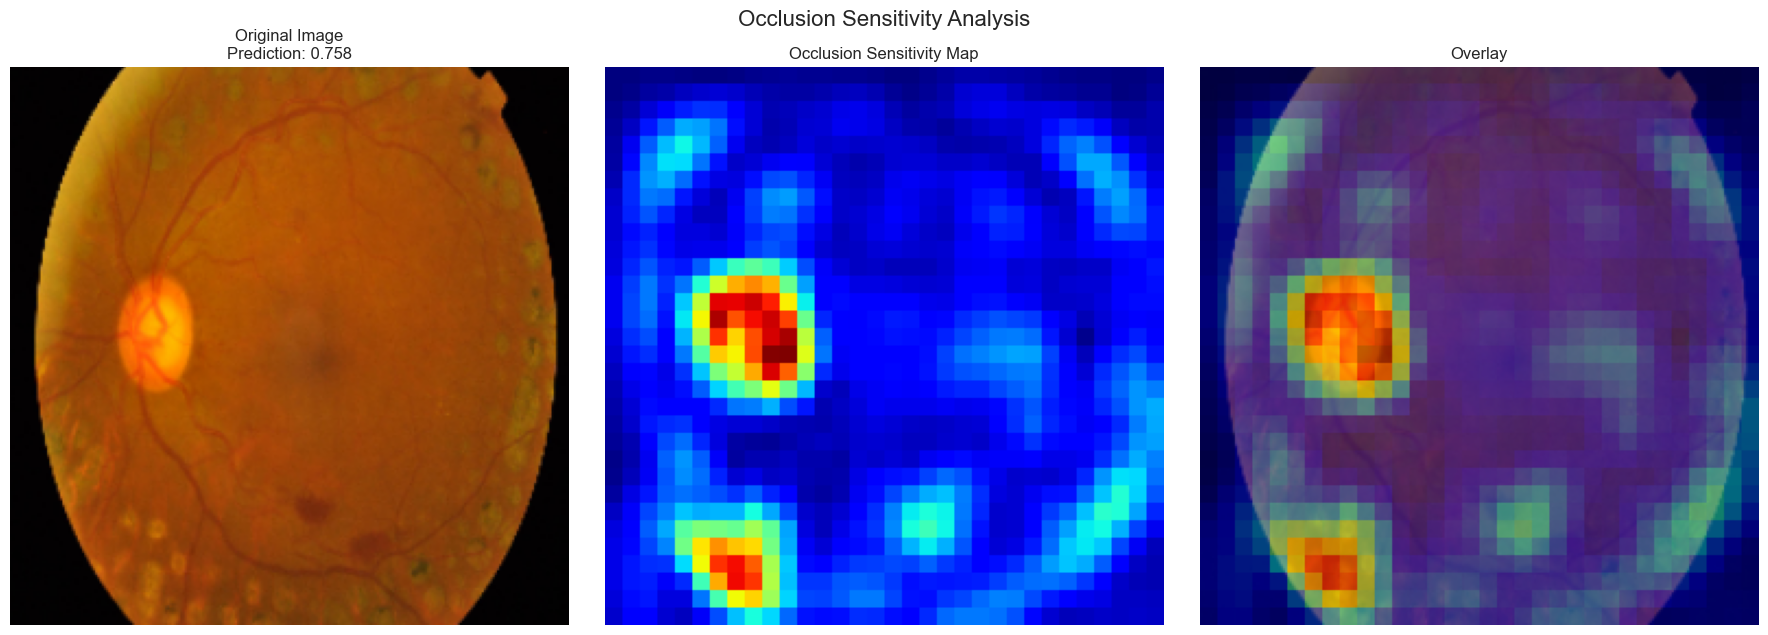

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

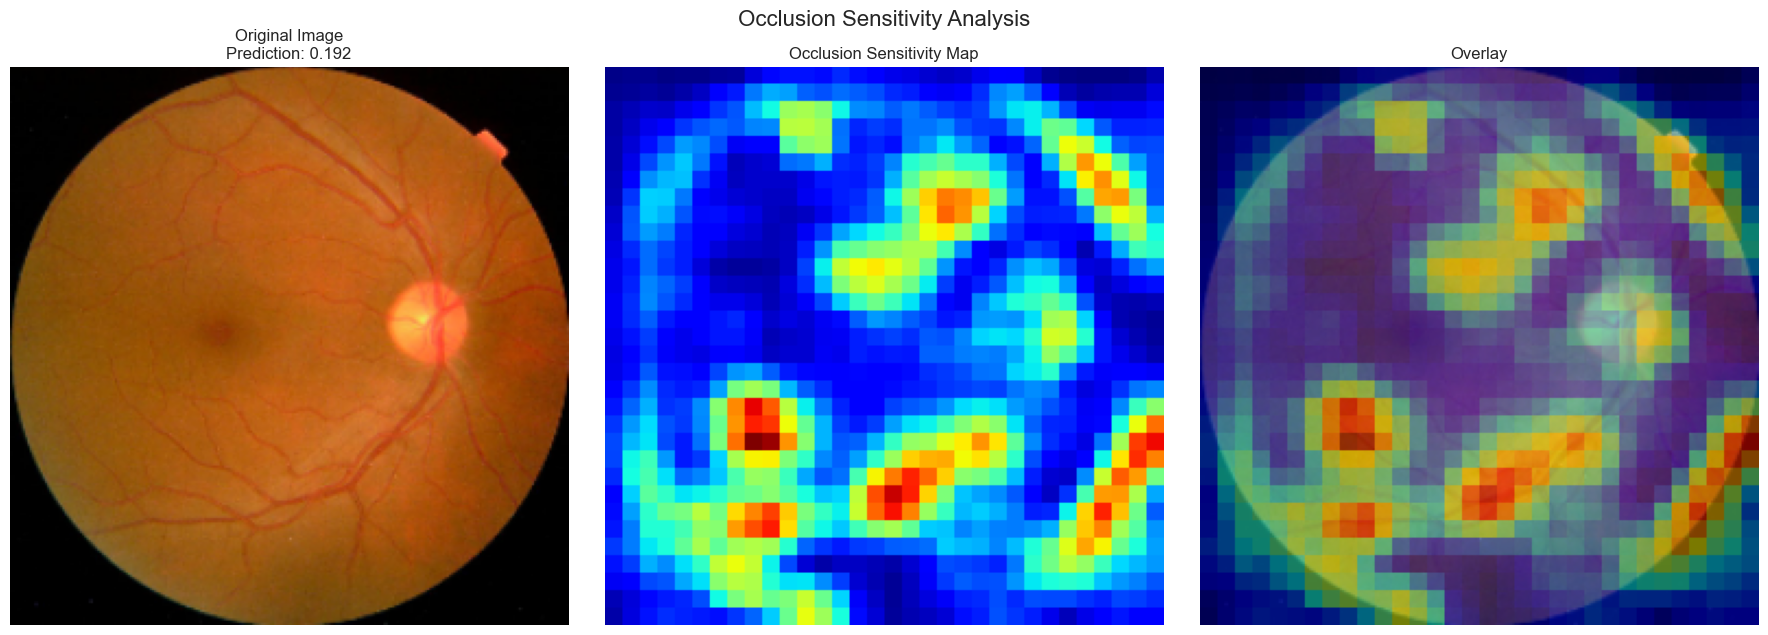

Occlusion sensitivity analysis completed. Areas with higher values in the sensitivity map indicate regions that strongly influence the model's decision.


In [111]:
# Call the occlusion sensitivity function for positive and negative examples
# Select a representative image (One where the model prediction is correct)
sample_image_path = os.path.join(IMAGE_PATH, f"{test_df[test_df['diagnosis'] == 1].iloc[0]['id_code']}.png")
sample_label = 1  # The true class of the selected image

# Run the occlusion sensitivity analysis
sensitivity_map = occlusion_sensitivity(
    model=model, 
    image_path=sample_image_path, 
    label=sample_label, 
    patch_size=24,  # Size of the occlusion patch
    stride=8        # Step size for moving the patch
)

# You can also run this for a negative example for comparison
sample_image_path_neg = os.path.join(IMAGE_PATH, f"{test_df[test_df['diagnosis'] == 0].iloc[0]['id_code']}.png")
sensitivity_map_neg = occlusion_sensitivity(
    model=model, 
    image_path=sample_image_path_neg, 
    label=0, 
    patch_size=24, 
    stride=8
)

print("Occlusion sensitivity analysis completed. Areas with higher values in the sensitivity map indicate regions that strongly influence the model's decision.")

## 19. Inference for new Images

In [104]:
def predict_dr_from_image(model, image_path, show_gradcam=True):
    """
    Predict whether an image shows signs of Diabetic Retinopathy.
    
    Args:
        model: Trained DR detection model
        image_path: Path to the image file
        show_gradcam: Whether to show Grad-CAM visualization (default: True)
    
    Returns:
        predicted_class: 0 (no/mild DR) or 1 (moderate/severe/proliferative DR)
        confidence: Prediction confidence (0-1)
    """
    # Check if the file exists
    if not os.path.exists(image_path):
        print(f"Error: File not found at {image_path}")
        return None, None
    
    try:
        # Preprocess the image using the same pipeline used for training
        img = preprocess_image(image_path)
        img_array = np.expand_dims(img, axis=0)
        
        # Make prediction
        prediction = model.predict(img_array)[0][0]
        predicted_class = 1 if prediction > 0.5 else 0
        confidence = prediction if predicted_class == 1 else 1 - prediction
        
        # Load original image for display
        original_img = cv2.imread(image_path)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        
        # Set up the figure
        if show_gradcam:
            plt.figure(figsize=(15, 5))
        else:
            plt.figure(figsize=(8, 6))
        
        # Display original image and prediction
        if show_gradcam:
            plt.subplot(1, 3, 1)
        plt.imshow(original_img)
        
        # Determine prediction label
        if predicted_class == 0:
            pred_label = "No/Mild DR"
            color = 'green'
        else:
            pred_label = "Moderate/Severe DR"
            color = 'red'
        
        plt.title(f"Prediction: {pred_label}\nConfidence: {confidence:.2%}", 
                 color=color, fontweight='bold')
        plt.axis('off')
        
        # Show Grad-CAM visualization if requested
        if show_gradcam:
            # Find appropriate layer for Grad-CAM
            target_layer = None
            
            # Try to find an appropriate layer for visualization
            for layer_name in ['top_activation', 'block7a_se_excite', 'block6a_activation']:
                try:
                    if model.get_layer(layer_name) is not None:
                        target_layer = layer_name
                        break
                except:
                    continue
            
            if target_layer is None:
                # Fall back to the last convolutional layer
                for layer in reversed(model.layers):
                    if isinstance(layer, tf.keras.layers.Conv2D):
                        target_layer = layer.name
                        break
            
            if target_layer is not None:
                # Generate Grad-CAM heatmap
                heatmap = make_gradcam_heatmap(img_array, model, target_layer)
                
                # Display heatmap
                plt.subplot(1, 3, 2)
                plt.imshow(heatmap, cmap='jet')
                plt.title("Attention Heatmap")
                plt.axis('off')
                
                # Display superimposed image
                _, cam_img = display_gradcam(image_path, heatmap)
                plt.subplot(1, 3, 3)
                plt.imshow(cam_img)
                plt.title("Grad-CAM Visualization")
                plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Provide clinical interpretation
        print("\n===== Diabetic Retinopathy Screening Result =====")
        print(f"Prediction: {pred_label}")
        print(f"Confidence: {confidence:.2%}")
        return predicted_class, confidence
        
    except Exception as e:
        print(f"Error processing image: {e}")
        return None, None

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


C:\Users\HP\PycharmProjects\MV_CW2\venv\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


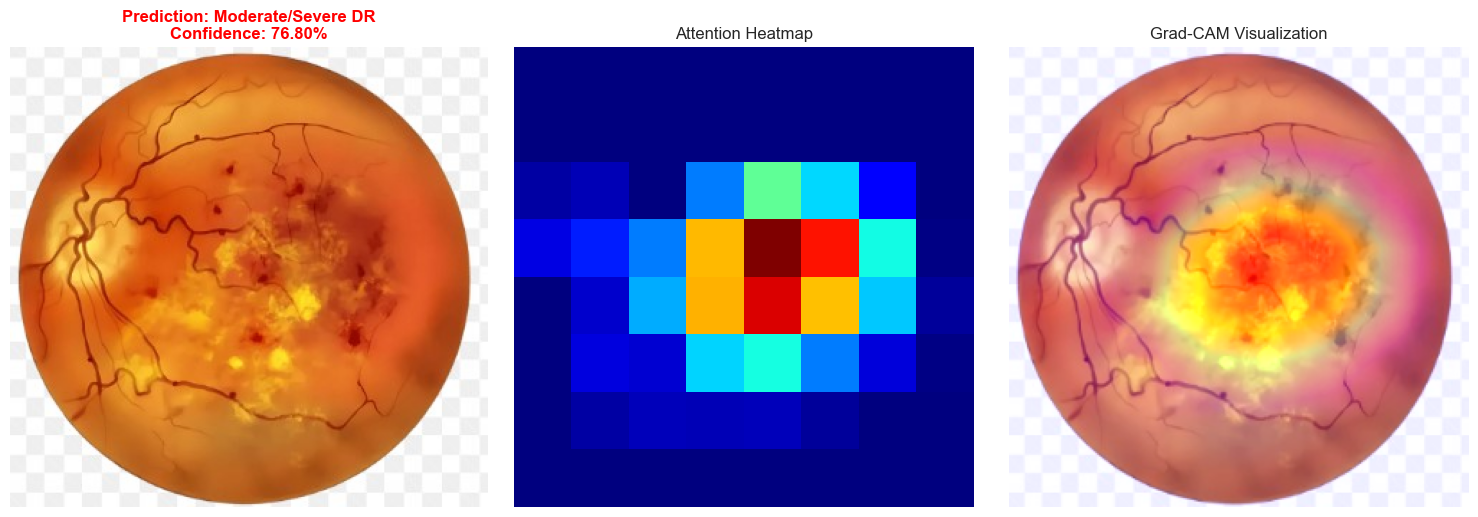


===== Diabetic Retinopathy Screening Result =====
Prediction: Moderate/Severe DR
Confidence: 76.80%


In [106]:
# Test real life prediction for DR (1) image
predicted_class, confidence = predict_dr_from_image(model, r"C:\Users\HP\PycharmProjects\MV_CW2\test_image1_dr.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


C:\Users\HP\PycharmProjects\MV_CW2\venv\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


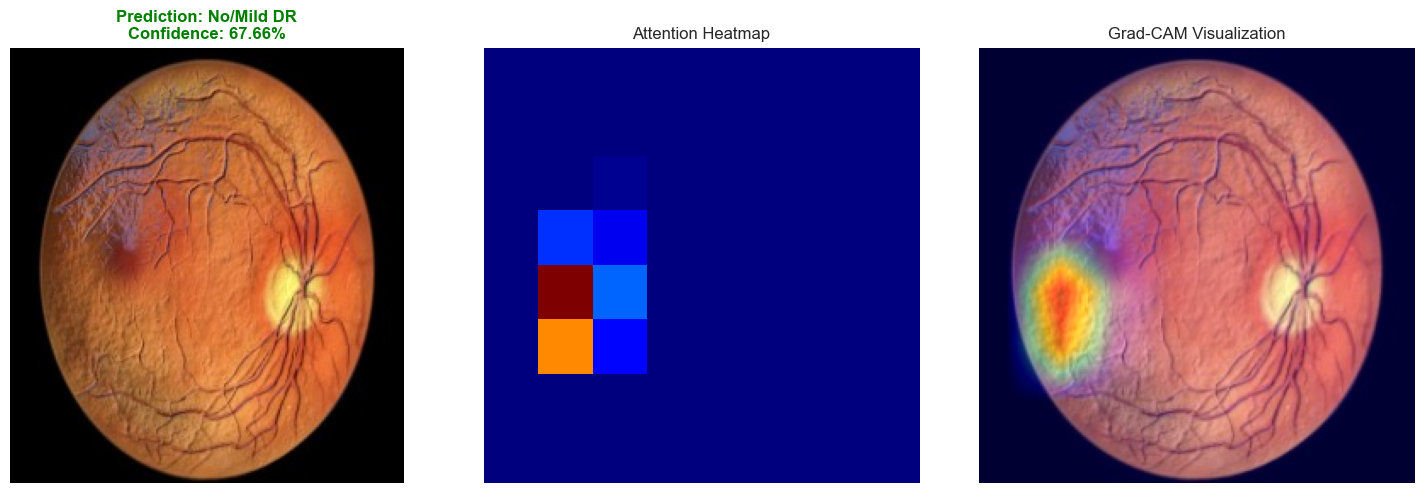


===== Diabetic Retinopathy Screening Result =====
Prediction: No/Mild DR
Confidence: 67.66%


In [107]:
# Test real life prediction for no DR (0) image
predicted_class, confidence = predict_dr_from_image(model, r"C:\Users\HP\PycharmProjects\MV_CW2\test_image2_no_dr.jpg")

## 20. Save model

In [108]:
# Save the final model
final_model_path = os.path.join(MODEL_SAVE_PATH, f'dr_detection_final_model_{timestamp}.h5')
model.save(final_model_path)
print(f"\nFinal model saved to: {final_model_path}")


Final model saved to: D:\MV_CW_Data\models\dr_detection_final_model_20250326-202702.h5


# ===== FINAL MODEL PERFORMANCE SUMMARY =====
###  * Accuracy: 0.9549
###  * AUC-ROC: 0.9925
###  * F1 Score: 0.9542
###  * Precision: 0.9872
###  * Recall: 0.9233